In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the CSV files directly from URLs
train_df = pd.read_csv('https://raw.githubusercontent.com/snehuuu28/Excelr_Data_Science/main/Assignments/Assignment_7/Titanic_train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/snehuuu28/Excelr_Data_Science/main/Assignments/Assignment_7/Titanic_test.csv')

In [3]:
# Concatenate both DataFrames
df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
# Examine features, their types, and summary statistics
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.02006

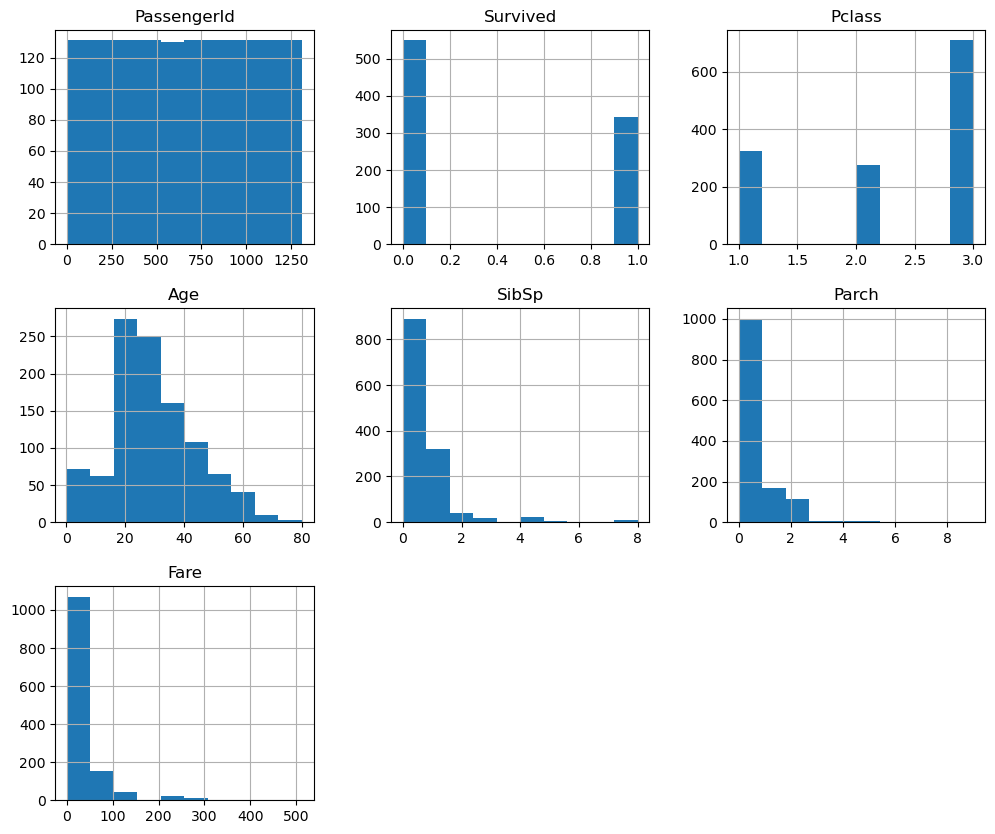

In [5]:
# Visualize distributions and relationships
df.hist(figsize=(12, 10))
plt.show()

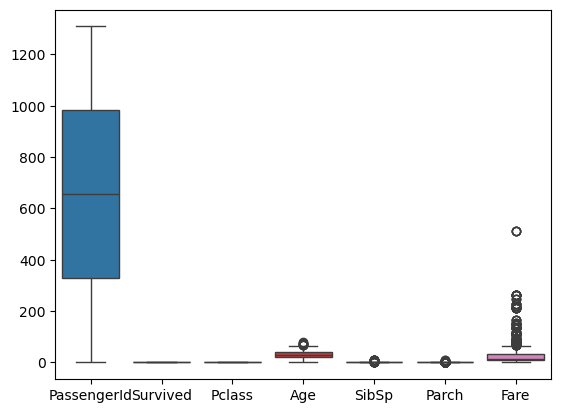

In [6]:
# Box plots to detect outliers
sns.boxplot(data=df)
plt.show()

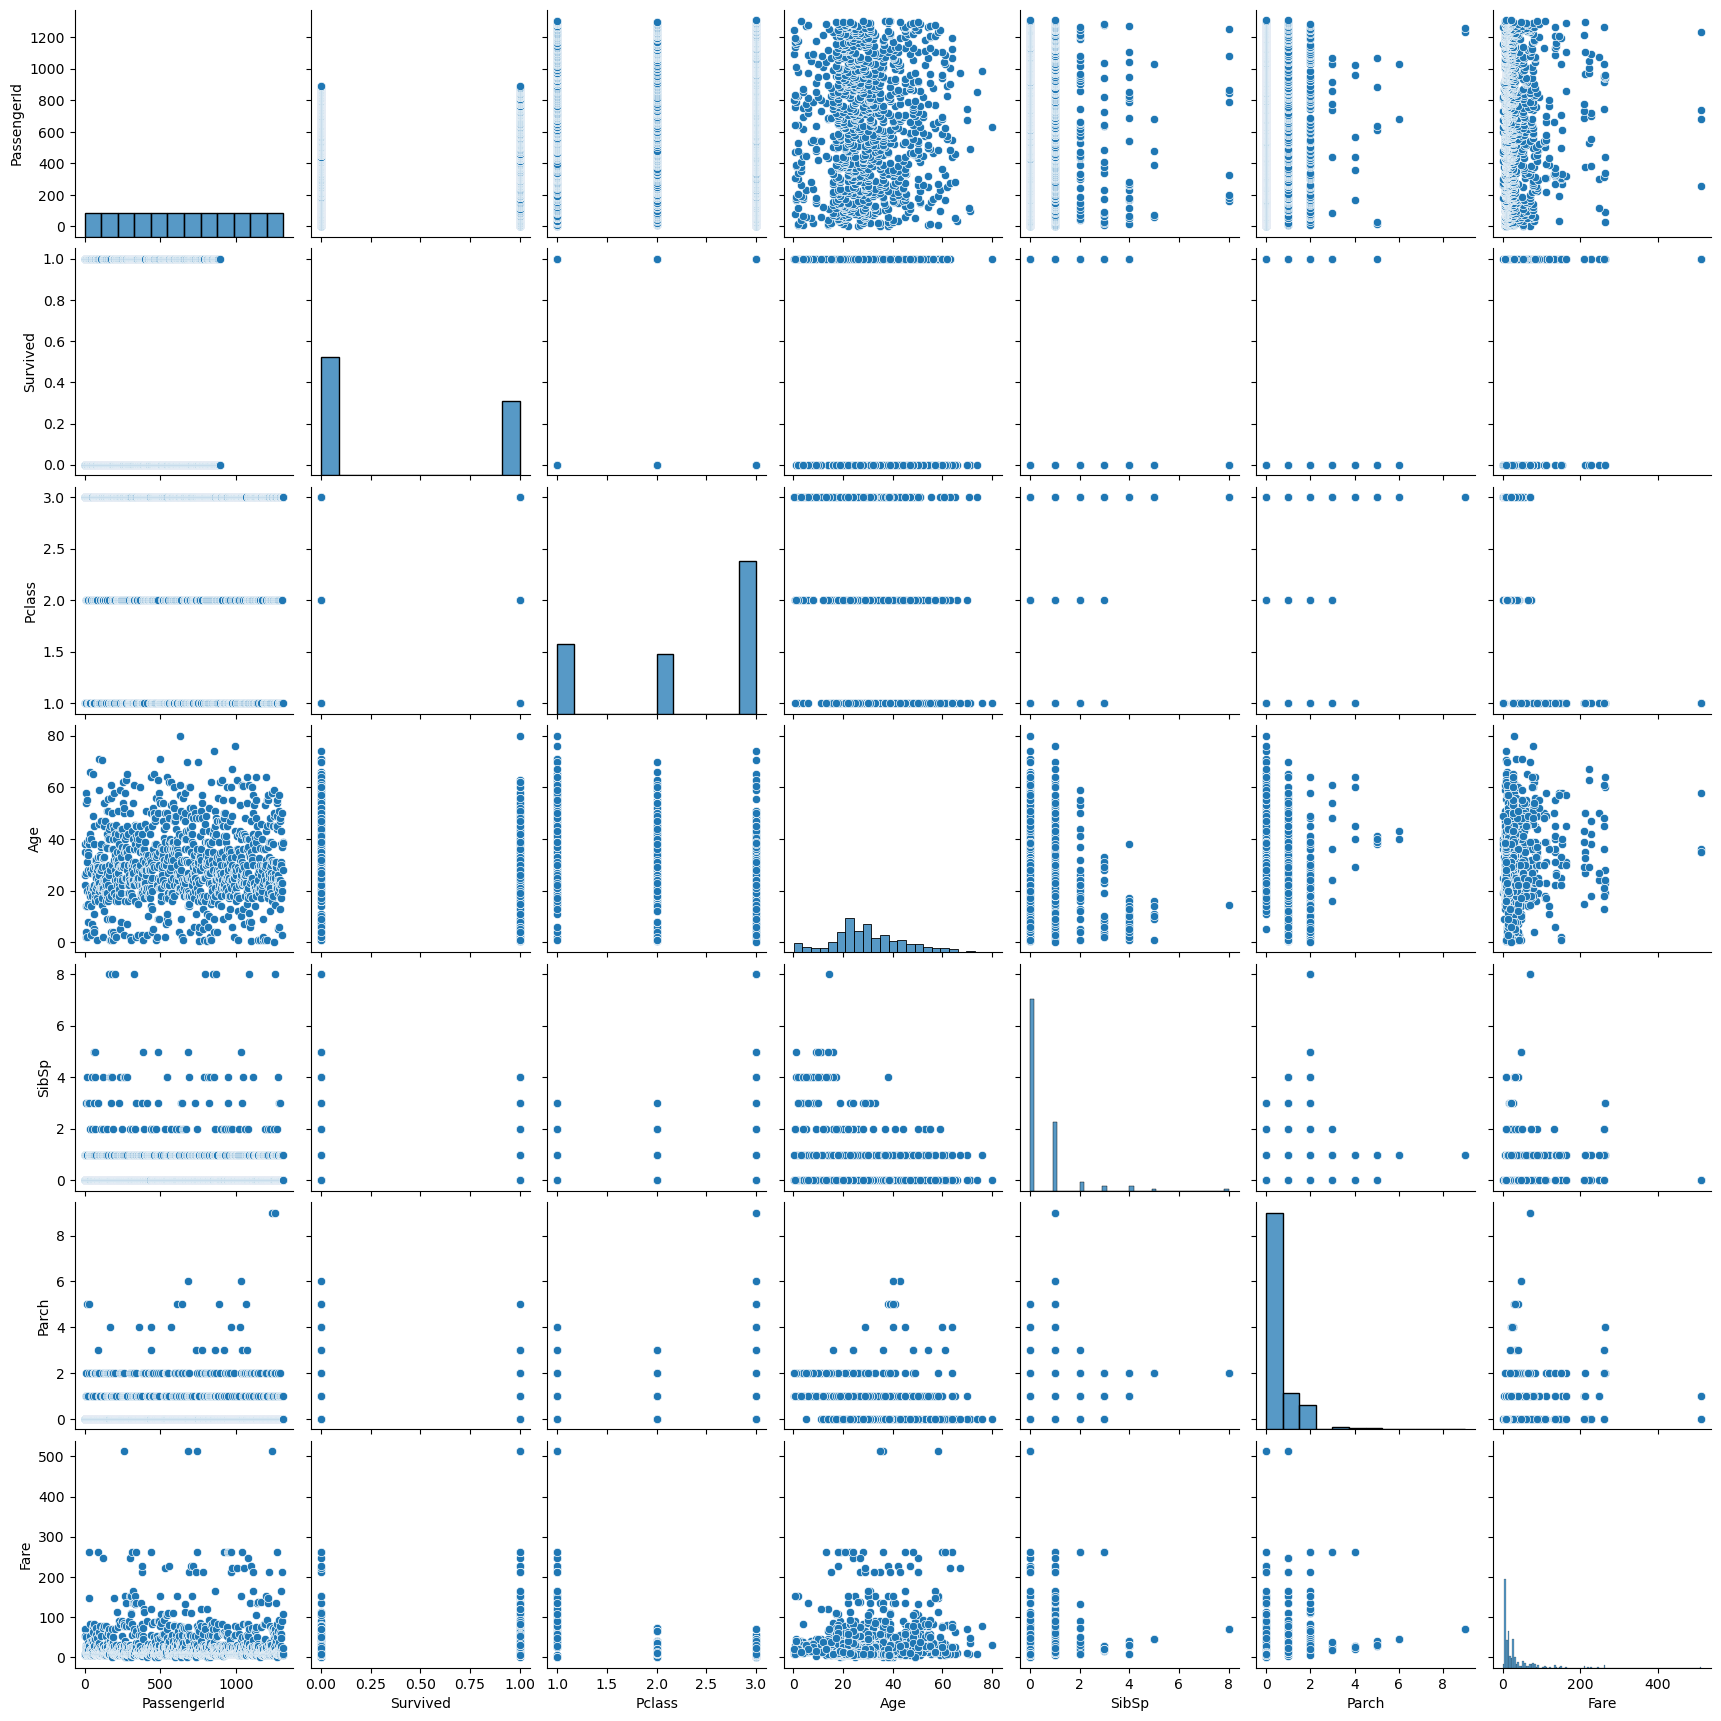

In [7]:
# Pair plots to visualize relationships between features
sns.pairplot(df)
plt.show()

In [8]:
# Step 2: Data Preprocessing

In [9]:
# Drop unwanted columns
df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'], inplace=True)

In [10]:
# Label encoding for 'Sex' and 'Embarked'
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [11]:
# Impute missing values for numerical columns
imputer = SimpleImputer(strategy='mean')
df['Age'] = imputer.fit_transform(df[['Age']])

# Impute missing values for 'Fare' with median
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Fill missing values in 'Embarked' with the mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

#Fill Missing Value of 'Survived' with median
df['Survived'] = df['Survived'].fillna(df['Survived'].median())


In [12]:
# Check for missing values again
print(df.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [13]:
# Define numerical and categorical columns
numerical_cols = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_cols = ['Sex', 'Embarked', 'Pclass']

# Preprocessor with different strategies for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [14]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

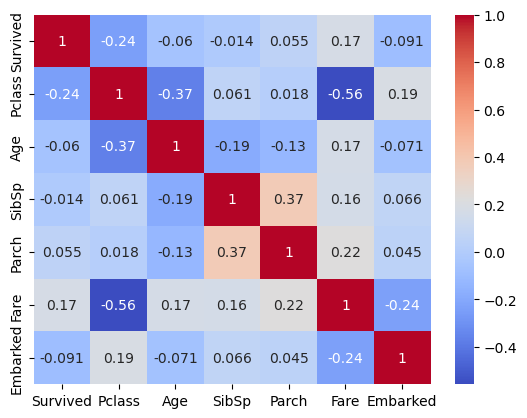

In [15]:
# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [16]:
# Step 3: Model Building

In [17]:
# Split data into training and testing sets
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Logistic regression model
logreg = LogisticRegression()

In [19]:
# Create the pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

In [20]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'Embarked',
                                                   'Pclass'])])),
                ('classifier', LogisticRegression())])

# Step 4: Model Evaluation

In [22]:
# Make predictions
y_pred = pipeline.predict(X_test)

In [23]:
# Calculate accuracy, precision, recall, F1-score, and ROC-AUC score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

In [24]:
# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.7709923664122137
Precision: 0.6511627906976745
Recall: 0.3835616438356164
F1-Score: 0.4827586206896552
ROC-AUC: 0.7849170109444081


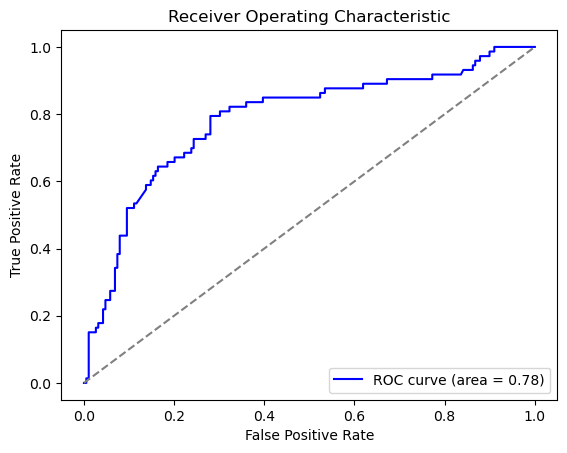

In [25]:
# ROC curve visualization
fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Step 5: Interpretation

In [27]:
# Access the columns after preprocessing
# Get the transformed feature names from the preprocessor
preprocessor = pipeline.named_steps['preprocessor']
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(input_features=categorical_cols)

# Combine numerical and categorical feature names
all_feature_names = numerical_cols + list(cat_features)

# Get the logistic regression coefficients
coefficients = pd.DataFrame(pipeline.named_steps['classifier'].coef_.flatten(), index=all_feature_names, columns=['Coefficient'])

# Print the coefficients
print(coefficients)


              Coefficient
Age             -0.025734
Fare             0.000251
SibSp           -0.185571
Parch           -0.055265
Sex_0            0.954583
Sex_1           -0.911665
Embarked_0.0     0.044976
Embarked_1.0     0.082754
Embarked_2.0    -0.084812
Pclass_1         0.723882
Pclass_2         0.070518
Pclass_3        -0.751482


In [28]:
# Step 6: Deployment with Streamlit

In [29]:
import pickle

pickle.dump(pipeline, open('pipeline_model.pkl', 'wb'))